---
# **Introduction to Deep Learning Chapter 3**

# Fine-tuning with original dataset
---


## **Install libraries and tools**
**Execute this code beforehand**

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# A small package to create visualizations of PyTorch execution graphs and traces.
# https://github.com/szagoruyko/pytorchviz
!pip install torchviz | tail -n 1
from torchviz import make_dot  # visualize the PyTorch models

# Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch, 
# similar to Tensorflow's model.summary() API to view the visualization of the model,
# which is helpful while debugging your network.
# https://github.com/TylerYep/torchinfo
!pip install torchinfo | tail -n 1
from torchinfo import summary  # display the summary of PyTorch models

# Set random seed (reproduce the same results every time)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


## **Device allocation**
**Execute this code beforehand**

In [2]:
# Device allocation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Check GPU status**

In [3]:
!nvidia-smi

Thu Jan 26 12:18:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    26W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **define utility functions**
**Execute this code beforehand.**

This section defines some utility functions. Check the implementation of these functions as necessary.

In [4]:
# A function for learning process
def fit(model, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # import tqdm library (progress bar)
    from tqdm.notebook import tqdm

    start_epoch = len(history)
    end_epoch = start_epoch + num_epochs

    # training loop
    for i in range(start_epoch, end_epoch):
        train_acc, train_loss = 0, 0
        val_acc, val_loss = 0, 0
        n_train, n_test = 0, 0

        # minibatch loop　（Learing phase)
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device) # send inputs to GPU
            labels = labels.to(device) # send inputs to GPU
    
            n_train += len(labels)              # count the number of training data
            optimizer.zero_grad()               # gradient initialization
            outputs = model(inputs)             # [Step1] prediction(forward calculation)
            loss = criterion(outputs, labels)   # [Step2] loss calculation
            loss.backward()                     # [Step3] backward propabation
            optimizer.step()                    # [Step4] parameter update

            prediction = torch.max(outputs, 1)[1]            # predicted label
            train_loss += loss.item()                        # loss
            train_acc += (prediction == labels).sum().item() # accuracy

        # Validation phase
        model.eval()
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            n_test += len(labels_test)          # count the number of test data
            outputs_test = model(inputs_test)                   # prediction(forward calculation)
            loss_test = criterion(outputs_test, labels_test)    # loss calculation
            prediction_test = torch.max(outputs_test, 1)[1]     # predected label

            val_loss +=  loss_test.item()   #loss
            val_acc +=  (prediction_test == labels_test).sum().item()  # accuracy

        # record loss and accuracy
        train_acc = train_acc / n_train
        val_acc = val_acc / n_test
        train_loss = train_loss / n_train
        val_loss = val_loss / n_test
        print (f'Epoch [{i+1}/{end_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([i+1 , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

    return history


def show_loss_and_accuracy_graph(history):
    # Check loss and accuracy
    print(f'Before learning: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}')
    print(f'After learning : Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}')

    # Display learning curve (Loss)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,1], 'b', label='training')
    plt.plot(history[:,0], history[:,3], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('learning curve(loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,2], 'b', label='training')
    plt.plot(history[:,0], history[:,4], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('learning curve(accuracy)')
    plt.legend()
    plt.show()


def show_confusion_matrix(model, dataloader, class_names, device):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs_test, labels_test in dataloader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            
            outputs_test = model(inputs_test)     # prediction(forward calculation)
            prediction_test = torch.max(outputs_test, 1)[1].data.cpu().numpy()  # predected label
            y_pred.extend(prediction_test) # Save Prediction
            
            labels = labels_test.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(cmap=plt.cm.Blues, ax=ax)


def show_misrecognizd_images(model, dataloader, img_shape, class_names, device):
    count = 0

    # Display 50 images with "correct label : prediction"
    plt.figure(figsize=(15, 20))
    for images, labels in dataloader:
        # obtain predicted labels
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.max(outputs, 1)[1]

        for i in np.arange(images.shape[0]):
            image_np = images[i].numpy().copy() # Tensor to NumPy
            label = labels[i]
            pred = predicted[i]
            if (pred != label):
                ax = plt.subplot(10, 10, count+1)
                img = image_np.reshape(img_shape)
                if(len(img_shape) == 3):
                    img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)
                img = (img + 1)/2   # Revert the range of values ​​from [-1,1] to [0,1]

                # show result
                plt.imshow(img, cmap='gray')
                ax.set_title(f'{class_names[label]}:{class_names[pred]}')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                count += 1
                if count == 100:
                    break
        else:
            continue
        break

    plt.show()


def show_image(img, imgtype='np', cmap='gray', figsize=(10,6), vmin=None, vmax=None):
    if(imgtype == "tensor"):
        img = img.numpy()

    if(imgtype == "np" or imgtype == "tensor"):
        if(len(img.shape) == 3):
            img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)        

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap, vmin, vmax)
    plt.show()

def show_kernels(model, kernel_key, figsize=(20,1), subplotsize=16, img_max_num=48):
    kernels = np.array(model.state_dict()[kernel_key].cpu())
    kernel_num = kernels.shape[0]
    channel_num = kernels.shape[1]

    img_index = 0
    for k in range(kernel_num):
        for c in range(channel_num):
            if(img_index % subplotsize == 0):
                plt.show()
                plt.figure(figsize=figsize)

            plt.subplot(1, subplotsize, img_index % subplotsize + 1)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
            plt.title(f"k,c:{k},{c}")
            plt.imshow(kernels[k][c], cmap="gray")
            img_index += 1
            if(img_index >= img_max_num):
                break
        else:
            continue
        break

def feature_to_img(feature, nrow=4, img_width=1000):
    feature = feature.unsqueeze(1)  # (N, H, W) -> (N, C, H, W)
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)     # make images and arrange in a grid
    img = transforms.functional.to_pil_image(img)    # tensor to  PIL Image
    img_height = int(img_width * img.height / img.width)  # resize
    img = img.resize((img_width, img_height))
    return img

def show_features(features, nrow=10):
    for name, x in features.items():
        img = feature_to_img(feature=x, nrow=nrow)
        print(name, x.shape)
        display(img)

def save_checkpoint(model, optimizer, history, filepath):
    checkpoint = {
        'model_state_dict': model.to('cpu').state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
        }
    print("saving checkpoint '{}'".format(filepath))
    torch.save(checkpoint, filepath)


# Note: Input model & optimizer should be pre-defined.  This function only updates their states.
import os
def load_checkpoint(model, optimizer, filepath):

    if os.path.isfile(filepath):
        print("loading checkpoint '{}'".format(filepath))
    else:
        print("File not found: '{}'".format(filepath))
        return
    
    start_epoch = 0        
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    history = checkpoint['history']

    print(checkpoint)

    return model, optimizer, history

---
# 3.1 Using pre-trained VGG-16 model and fine-tuning
---


## **Example 3.1.1** Data Preparation of CIFER-10 for VGG-16 (Dataset, Transforms and DataLoader)

This is the same as Example 2.3.1

In [5]:
import torchvision.transforms as transforms     # Transforms
import torchvision.datasets as datasets         # for using dataset such as MNIST and CIFER-10
from torch.utils.data import DataLoader

### Transforms for preprocessing
transform_for_VGG16_train = transforms.Compose([
    transforms.Resize((64, 64)),             # resize from CIFER-10's shape 3x32x32 to 3x64x64
    transforms.RandomHorizontalFlip(p=0.5),  # for data augumentation
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False) # for data augumentation
])

transform_for_VGG16_test = transforms.Compose([
    transforms.Resize((64, 64)),      # resize from CIFER-10's shape 3x32x32 to 3x64x64
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


### Datasetsfor training and testing (CIFAR-10 Dataset)
data_root = './data'
train_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_VGG16_train
)

test_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_VGG16_test
)

class_names_CIFAR10 = ('airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck')

### DataLoader

batch_size = 50
train_loader_CIFAR10 = DataLoader(
    train_set_CIFAR10,
    batch_size = batch_size,
    shuffle = True
)

test_loader_CIFAR10 = DataLoader(
    test_set_CIFAR10,
    batch_size = batch_size,
    shuffle = False
)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **Example 3.1.2** Using pre-trained VGG-16 model

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model_vgg16pt = models.vgg16(weights='DEFAULT')  # model_vgg16pt: pre-trained vgg-16 model
model_vgg16pt = model_vgg16pt.to(device) # Send the model to GPU


# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer_vgg16pt = optim.SGD(model_vgg16pt.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
#optimizer = optim.Adam(model_vgg16.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_vgg16pt = np.zeros((0,5))

summary(model_vgg16pt, (10,3,64,64), depth=2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [10, 1000]                --
├─Sequential: 1-1                        [10, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [10, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [10, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [10, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [10, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [10, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [10, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [10, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [10, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [10, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [10, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [10, 256, 16, 16]         29

## **Example 3.1.3** Change the output dimension to fit CIFER-10 dataset (10 classes)

Originally, VGG16 is pre-trained on ImageNet, which is a 1000 class image dataset.

In [7]:
print(model_vgg16pt.classifier[6])
print(model_vgg16pt.classifier[6].in_features)
print(model_vgg16pt.classifier[6].out_features)

Linear(in_features=4096, out_features=1000, bias=True)
4096
1000


In [8]:
in_features = model_vgg16pt.classifier[6].in_features
out_features = 10
model_vgg16pt.classifier[6] = nn.Linear(in_features, out_features)    # new Linear is created and connected
model_vgg16pt = model_vgg16pt.to(device) # Send the model to GPU

print(model_vgg16pt)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## **Example 3.1.4** Fine-tuning with VGG-16 model

It may take about 3 minutes per epoch with standard GPU.
But learing just 1 epoch provides good accuracy.
Of course, the more epochs learned, the higher the accuracy.
However, too many epochs will cause overfitting.

In [9]:
num_epochs = 1    # The number of learning loop

history_vgg16pt = fit(model = model_vgg16pt,
                     optimizer = optimizer_vgg16pt,
                     criterion = criterion,
                     num_epochs = num_epochs,
                     train_loader = train_loader_CIFAR10,
                     test_loader = test_loader_CIFAR10,
                     device = device,
                     history = history_vgg16pt)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1], loss: 0.01601 acc: 0.72568 val_loss: 0.00776, val_acc: 0.86960


In [15]:
### save as checkpoint
import os

data_dir = "./drive/MyDrive/IntroductionToDL/Model_VGG16pt"   # save all files to this dir in Google Drive
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

checkpoint_filename = 'checkpoint_vgg16pt_20epoch.cpt'  # we use '.cpt' for checkpoint file. This extension is not common
checkpoint_path = os.path.join(data_dir, checkpoint_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt
save_checkpoint(model_vgg16pt, optimizer_vgg16pt, history_vgg16pt, checkpoint_path)

saving checkpoint './drive/MyDrive/IntroductionToDL/Model_VGG16pt/checkpoint_vgg16pt_20epoch.cpt'


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Example 3.1.5** Show loss and accuracy

Before learning: Loss: 0.00776 Accuracy: 0.86960
After learning : Loss: 0.00776 Accuracy: 0.86960


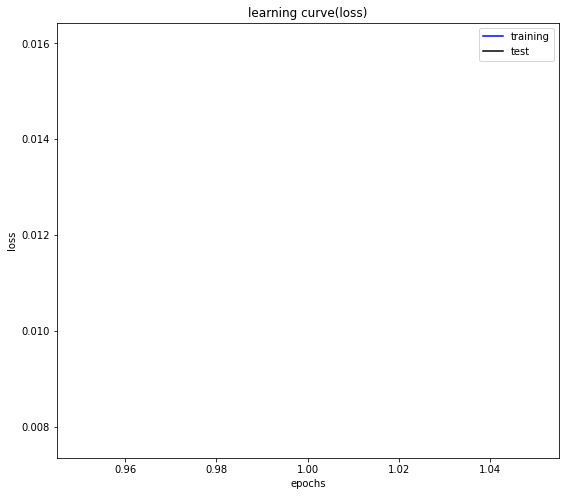

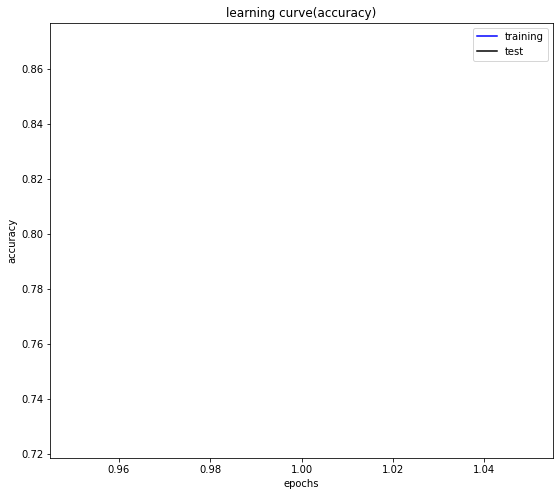

In [21]:
show_loss_and_accuracy_graph(history_vgg16pt)

## **Example 3.1.6** Show confusion matrix

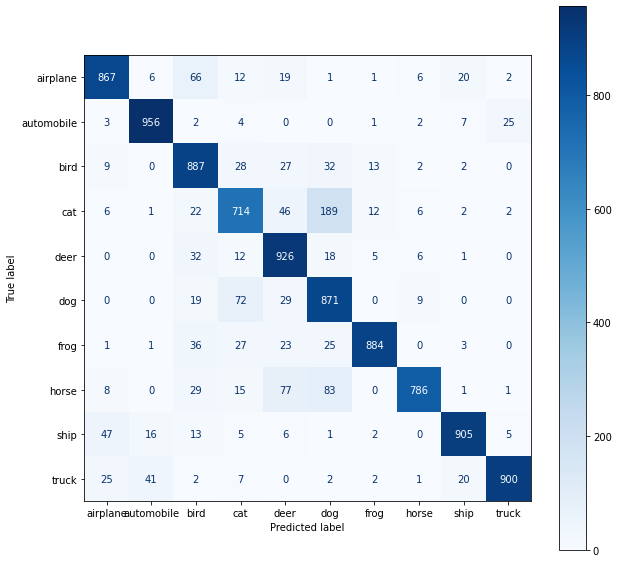

In [22]:
show_confusion_matrix(model=model_vgg16pt,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

## **Example 3.1.7** Show misrecognized images

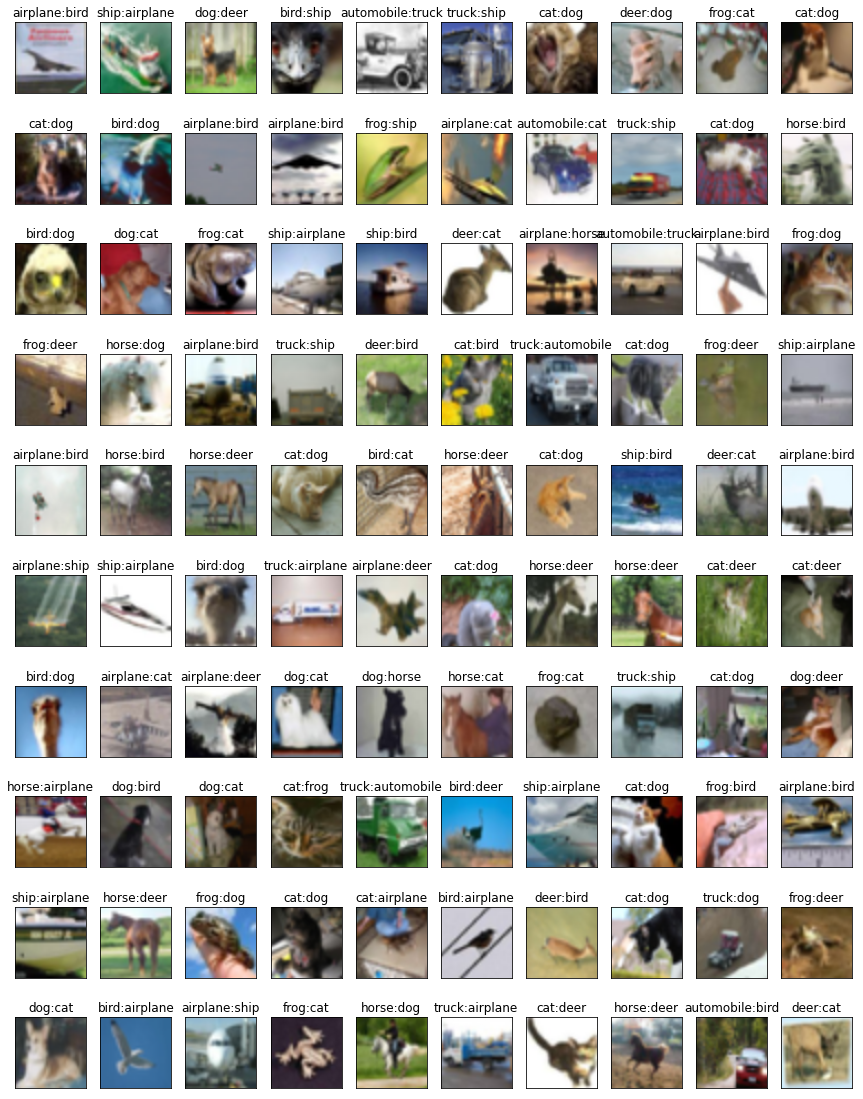

In [23]:
show_misrecognizd_images(model=model_vgg16pt,
                         dataloader=test_loader_CIFAR10,
                         img_shape=(3, 64, 64),
                         class_names=class_names_CIFAR10,
                         device=device)

## **Exercise 3.1** Using pre-trained parameters with CIFER-10 for pre-trained VGG-16 model

In [30]:
import os

data_dir = "./drive/MyDrive/IntroductionToDL/Model_VGG16pt"   # Google Drive directory
checkpoint_filename = 'checkpoint_vgg16pt_20epoch.cpt'  # checkpoint filename

checkpoint_path = os.path.join(data_dir, checkpoint_filename)

model_vgg16pt, optimizer_vgg16pt, history_vgg16pt = load_checkpoint(model_vgg16pt, optimizer_vgg16pt, checkpoint_path)
model_vgg16pt = model_vgg16pt.to(device)

# Transfer the optimizer parts to GPU
# see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/13
for state in optimizer_vgg16pt.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

Streaming output truncated to the last 5000 lines.
          [ 3.5791e-02,  3.5624e-03, -2.5761e-02],
          [-1.2385e-02, -1.8807e-02, -5.1239e-02]],

         [[-4.7685e-02,  2.1686e-02,  7.5356e-03],
          [-1.8691e-02, -4.5667e-02, -4.1266e-02],
          [-1.7778e-02, -7.8289e-03, -2.0831e-02]],

         ...,

         [[ 1.9152e-03, -3.1666e-02, -2.2613e-02],
          [-1.5141e-02,  3.0595e-02,  2.2900e-02],
          [-1.0586e-02,  6.7203e-02, -1.4069e-02]],

         [[ 1.0699e-02, -2.6084e-03, -6.3876e-03],
          [ 3.5669e-02,  8.1956e-03, -2.2751e-02],
          [ 6.1868e-03, -2.4884e-02, -5.9757e-03]],

         [[-3.9915e-02, -3.3526e-03, -2.4999e-02],
          [ 5.4494e-02,  3.7114e-02,  2.5451e-02],
          [ 1.9229e-02, -1.1515e-02,  3.9171e-03]]],


        [[[-1.2710e-02, -4.7206e-02, -5.8463e-02],
          [-2.0578e-02, -3.1492e-02,  1.4697e-02],
          [-2.3858e-02,  3.7527e-02,  1.8264e-02]],

         [[ 1.9114e-02,  1.4737e-02, -1.1083e-02],
  

Before learning: Loss: 0.00753 Accuracy: 0.87550
After learning : Loss: 0.00458 Accuracy: 0.93530


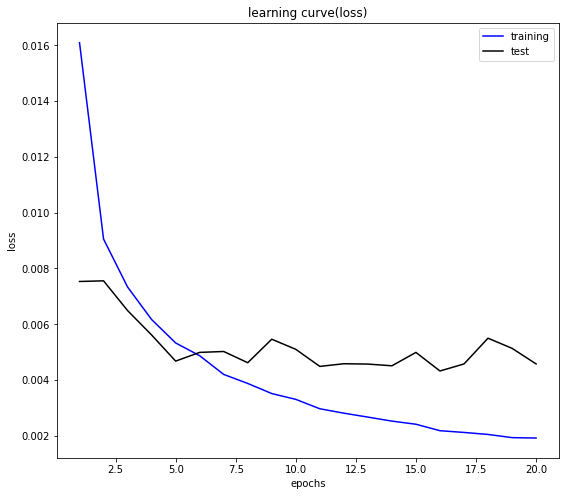

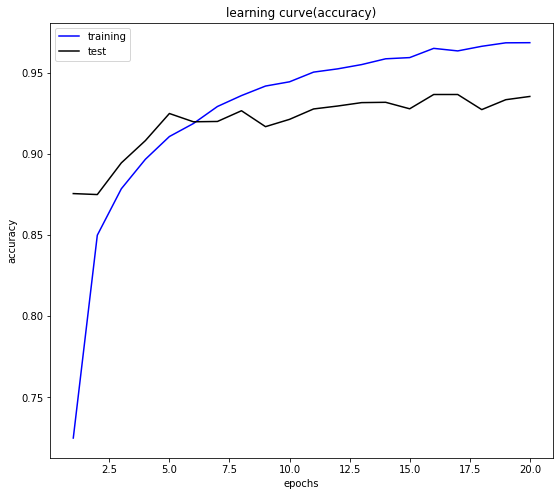

In [36]:
show_loss_and_accuracy_graph(history_vgg16pt)

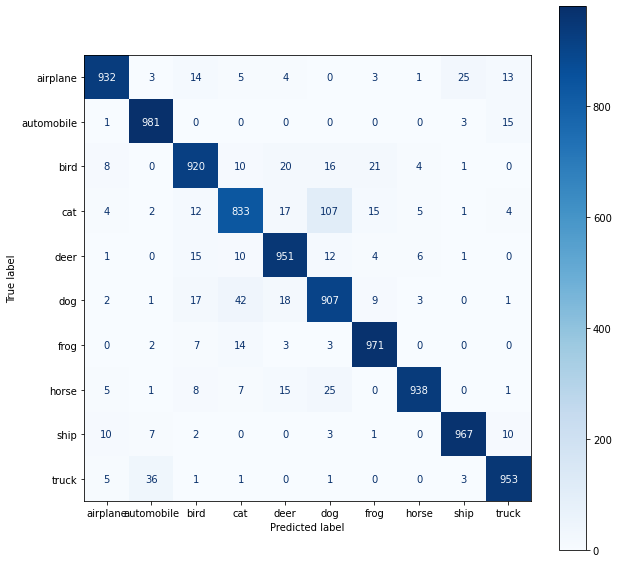

In [37]:
show_confusion_matrix(model=model_vgg16pt,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

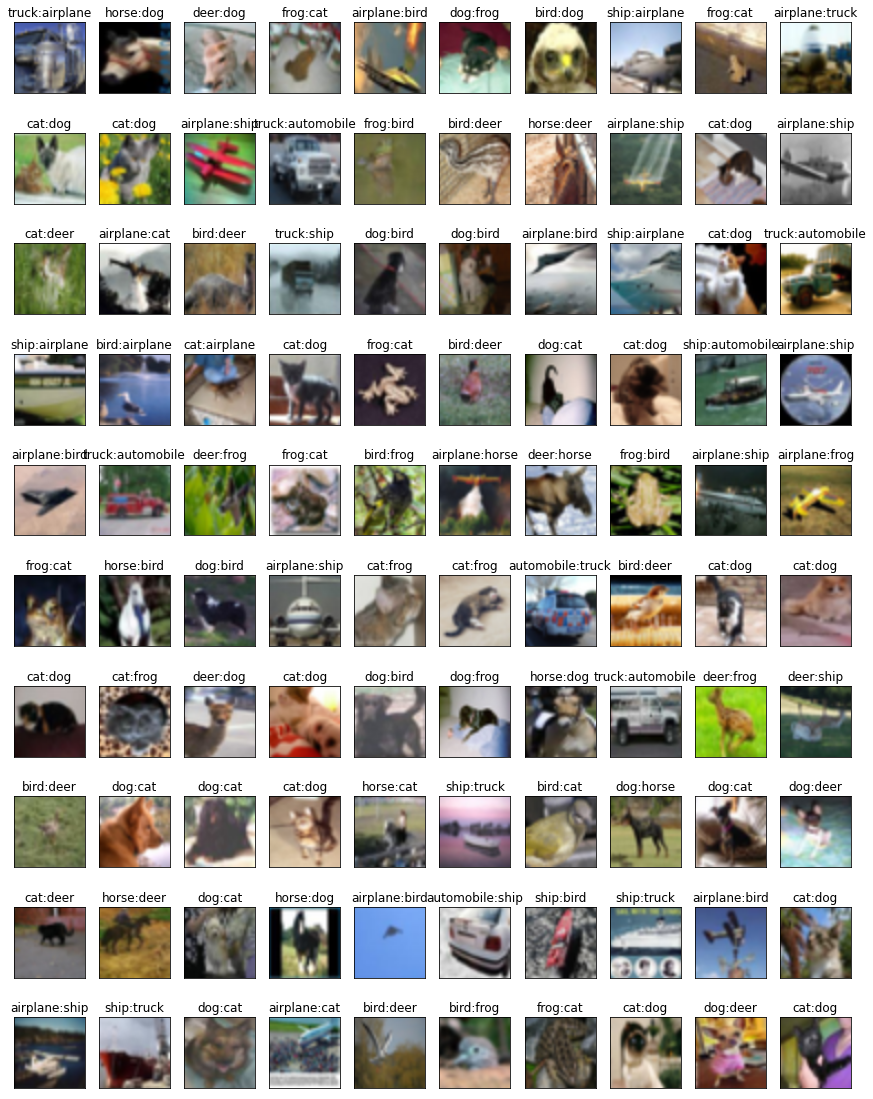

In [38]:
show_misrecognizd_images(model=model_vgg16pt,
                         dataloader=test_loader_CIFAR10,
                         img_shape=(3, 64, 64),
                         class_names=class_names_CIFAR10,
                         device=device)

---
# 3.2 GoogLeNet
---


## **Example 3.2.1** Using pre-trained GoogLeNet model

https://pytorch.org/vision/stable/models/googlenet.html
https://pytorch.org/vision/stable/models/generated/torchvision.models.googlenet.html#torchvision.models.googlenet

In [31]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model_googlenet = models.googlenet(weights='DEFAULT')  # model_vgg16pt: pre-trained vgg-16 model 
model_googlenet = model_googlenet.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer_googlenet = optim.SGD(model_googlenet.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
#optimizer_googlenet = optim.Adam(model_googlenet.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_googlenet = np.zeros((0,5))

#print(model_googlenet)
summary(model_googlenet, (10,3,64,64), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [10, 1000]                --
├─BasicConv2d: 1-1                       [10, 64, 32, 32]          9,536
├─MaxPool2d: 1-2                         [10, 64, 16, 16]          --
├─BasicConv2d: 1-3                       [10, 64, 16, 16]          4,224
├─BasicConv2d: 1-4                       [10, 192, 16, 16]         110,976
├─MaxPool2d: 1-5                         [10, 192, 8, 8]           --
├─Inception: 1-6                         [10, 256, 8, 8]           155,872
├─Inception: 1-7                         [10, 480, 8, 8]           340,224
├─MaxPool2d: 1-8                         [10, 480, 4, 4]           --
├─Inception: 1-9                         [10, 512, 4, 4]           364,512
├─Inception: 1-10                        [10, 512, 4, 4]           425,232
├─Inception: 1-11                        [10, 512, 4, 4]           486,192
├─Inception: 1-12                        [10, 528

## **Example 3.2.2** Change the output dimension to fit CIFER-10 dataset (10 classes)

Originally, GoogLeNeta is pre-trained on ImageNet, which is a 1000 class image dataset.

In [32]:
print(model_googlenet.fc)

Linear(in_features=1024, out_features=1000, bias=True)


In [33]:
in_features = model_googlenet.fc.in_features
out_features = 10
model_googlenet.fc = nn.Linear(in_features, out_features)    # new Linear is created and connected
model_googlenet = model_googlenet.to(device) # Send the model to GPU

print(model_googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## **Example 3.2.3** Fine-tuning with GoogLeNet model

In [34]:
num_epochs = 3    # The number of learning loop

history_googlenet = fit(model = model_googlenet,
                     optimizer = optimizer_googlenet,
                     criterion = criterion,
                     num_epochs = num_epochs,
                     train_loader = train_loader_CIFAR10,
                     test_loader = test_loader_CIFAR10,
                     device = device,
                     history = history_googlenet)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/3], loss: 0.01740 acc: 0.70614 val_loss: 0.00973, val_acc: 0.83570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/3], loss: 0.01077 acc: 0.81740 val_loss: 0.00854, val_acc: 0.85420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/3], loss: 0.00892 acc: 0.84798 val_loss: 0.00682, val_acc: 0.88600


## **Exercise 3.2** Checking the accuracy of GoogLeNetVGG-16 model

Execute examples from 3.2.1 to 3.2.3. Then check the classification accuracy and show the confusion matrix.


val_acc: 0.88600

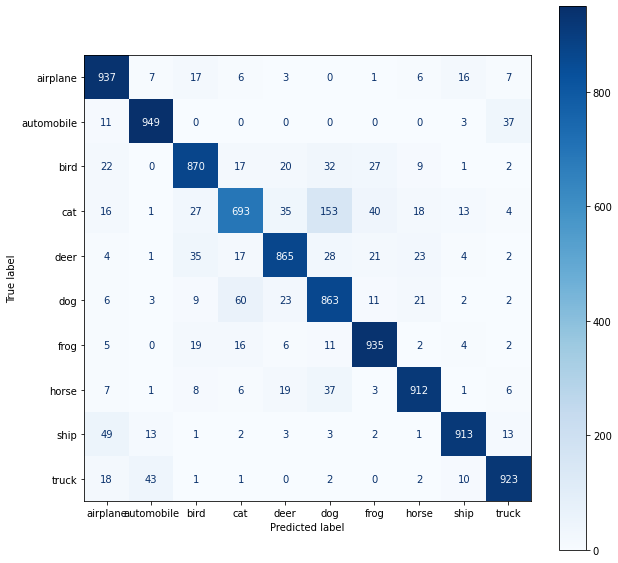

In [35]:
show_confusion_matrix(model=model_googlenet,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

---
# 3.3 ResNet (ResNet50)
---

## **Example 3.3.1** Using pre-trained ResNet50 model

https://pytorch.org/vision/stable/models/resnet.html
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

In [39]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model_resnet50 = models.resnet50(weights='DEFAULT')  # model_vgg16pt: pre-trained vgg-16 model 
print(model_resnet50)

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer_resnet50 = optim.SGD(model_resnet50.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
#optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_resnet50 = np.zeros((0,5))

#print(model_googlenet)
summary(model_resnet50, (10,3,64,64), depth=1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 1000]                --
├─Conv2d: 1-1                            [10, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [10, 64, 32, 32]          128
├─ReLU: 1-3                              [10, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [10, 64, 16, 16]          --
├─Sequential: 1-5                        [10, 256, 16, 16]         215,808
├─Sequential: 1-6                        [10, 512, 8, 8]           1,219,584
├─Sequential: 1-7                        [10, 1024, 4, 4]          7,098,368
├─Sequential: 1-8                        [10, 2048, 2, 2]          14,964,736
├─AdaptiveAvgPool2d: 1-9                 [10, 2048, 1, 1]          --
├─Linear: 1-10                           [10, 1000]                2,049,000
Total params: 25,557,032
Trainable params: 25,557,032
Non-trainable params: 0
Total mult-adds (G): 3.36
Input size (M

## **Example 3.3.2** Change the output dimension to fit CIFER-10 dataset (10 classes)

Originally, ResNet is pre-trained on ImageNet, which is a 1000 class image dataset.

In [40]:
print(model_resnet50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [41]:
in_features = model_resnet50.fc.in_features
out_features = 10
model_resnet50.fc = nn.Linear(in_features, out_features)    # new Linear is created and connected
model_resnet50 = model_resnet50.to(device) # Send the model to GPU

print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **Example 3.3.3** Fine-tuning with ResNet50 model

In [42]:
num_epochs = 3    # The number of learning loop

history_resnet50 = fit(model = model_resnet50,
                     optimizer = optimizer_resnet50,
                     criterion = criterion,
                     num_epochs = num_epochs,
                     train_loader = train_loader_CIFAR10,
                     test_loader = test_loader_CIFAR10,
                     device = device,
                     history = history_resnet50)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/3], loss: 0.01382 acc: 0.76792 val_loss: 0.00605, val_acc: 0.89930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/3], loss: 0.00644 acc: 0.89196 val_loss: 0.00457, val_acc: 0.92530


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/3], loss: 0.00479 acc: 0.92004 val_loss: 0.00406, val_acc: 0.93180


val_acc: 0.93180

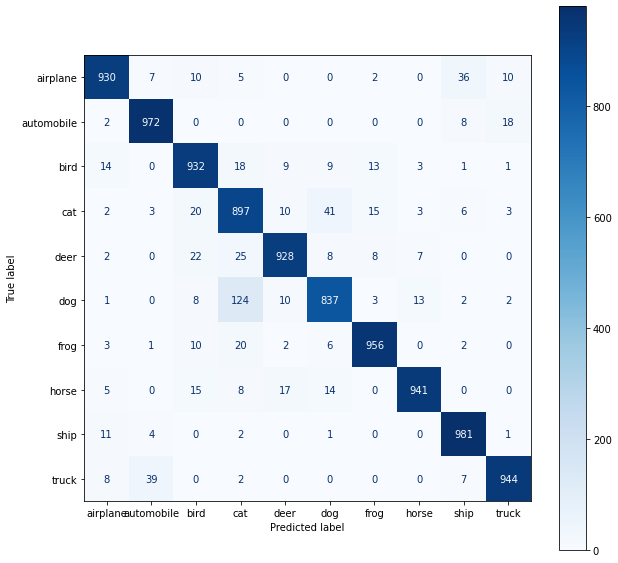

In [43]:
show_confusion_matrix(model=model_resnet50,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

---
# 3.4 Mobile Net v3
---



## **Example 3.4.1** Using pre-trained MobileNet v3 model

https://pytorch.org/vision/stable/models/mobilenetv3.html
https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.mobilenet_v3_small

In [44]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model_mobilenet_v3_small = models.mobilenet_v3_small(weights='DEFAULT')  # model_vgg16pt: pre-trained vgg-16 model 

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer_mobilenet_v3_small = optim.SGD(model_mobilenet_v3_small.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
#optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_mobilenet_v3_small = np.zeros((0,5))

print(model_mobilenet_v3_small)
#summary(model_mobilenet_v3_small, (10,3,64,64), depth=3)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## **Example 3.4.2** Change the output dimension to fit CIFER-10 dataset (10 classes)

Originally, MobileNet v3 is pre-trained on ImageNet, which is a 1000 class image dataset.

In [45]:
print(model_mobilenet_v3_small.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


In [46]:
in_features = model_mobilenet_v3_small.classifier[3].in_features
out_features = 10
model_mobilenet_v3_small.classifier[3] = nn.Linear(in_features, out_features)    # new Linear is created and connected
model_mobilenet_v3_small = model_mobilenet_v3_small.to(device) # Send the model to GPU

print(model_mobilenet_v3_small)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## **Example 3.4.3** Fine-tuning with MobileNet v3 model

In [47]:
num_epochs = 3    # The number of learning loop

history_mobilenet_v3_small = fit(model = model_mobilenet_v3_small,
                     optimizer = optimizer_mobilenet_v3_small,
                     criterion = criterion,
                     num_epochs = num_epochs,
                     train_loader = train_loader_CIFAR10,
                     test_loader = test_loader_CIFAR10,
                     device = device,
                     history = history_mobilenet_v3_small)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/3], loss: 0.02413 acc: 0.57478 val_loss: 0.01736, val_acc: 0.69290


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/3], loss: 0.01560 acc: 0.72834 val_loss: 0.01294, val_acc: 0.77560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/3], loss: 0.01338 acc: 0.76402 val_loss: 0.01237, val_acc: 0.78810


---
# 3.5 Using Custom Dataset
---

## **Example 3.5.1** Making original dataset from video

In [59]:
import cv2
import os

def video2image(videopath, save_dir, class_name, csv_name='list.csv', start_frame=0, stop_frame=-1, step_frame=1, img_width=256, basename='image', ext='jpg'):
    cap = cv2.VideoCapture(videopath)

    if not cap.isOpened():
        print(videopath, "could not open.")
        return

    os.makedirs(os.path.join(save_dir, class_name), exist_ok=True)
    csv_file = open(os.path.join(save_dir, csv_name), 'a', encoding='UTF-8')
    frame_num =int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_digit = len(str(frame_num))

    print(videopath, "has", frame_num, "frames")

    if stop_frame == -1:
        stop_frame = frame_num

    for n in range(start_frame, stop_frame, step_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        filename = '{}_{}.{}'.format(basename, str(n).zfill(frame_digit), ext)
        filepath = os.path.join(class_name, filename)
        if ret:
            frame = resize_to_width(frame, img_width)     # resize the frame
            cv2.imwrite(os.path.join(save_dir, filepath), frame)
            print(filepath + ',' + class_name, file=csv_file)
            print(filepath + ',' + class_name)
        else:
            return
    
    print("completed!")
    csv_file.close()

# Resizes the image with the specified width keeping aspect ratio
def resize_to_width(img, width):
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))
    return dst

In [60]:
video2image(videopath = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/rock1.mp4', # video file
            save_dir = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS',  # if you mout Google drive
            class_name = 'rock',
            csv_name='list.csv',
            start_frame=0,
            stop_frame=-1,  # -1 means last frame
            step_frame = 5,
            basename = 'images')

/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/rock1.mp4 has 1457 frames
rock/images_0000.jpg,rock
rock/images_0005.jpg,rock
rock/images_0010.jpg,rock
rock/images_0015.jpg,rock
rock/images_0020.jpg,rock
rock/images_0025.jpg,rock
rock/images_0030.jpg,rock
rock/images_0035.jpg,rock
rock/images_0040.jpg,rock
rock/images_0045.jpg,rock
rock/images_0050.jpg,rock
rock/images_0055.jpg,rock
rock/images_0060.jpg,rock
rock/images_0065.jpg,rock
rock/images_0070.jpg,rock
rock/images_0075.jpg,rock
rock/images_0080.jpg,rock
rock/images_0085.jpg,rock
rock/images_0090.jpg,rock
rock/images_0095.jpg,rock
rock/images_0100.jpg,rock
rock/images_0105.jpg,rock
rock/images_0110.jpg,rock
rock/images_0115.jpg,rock
rock/images_0120.jpg,rock
rock/images_0125.jpg,rock
rock/images_0130.jpg,rock
rock/images_0135.jpg,rock
rock/images_0140.jpg,rock
rock/images_0145.jpg,rock
rock/images_0150.jpg,rock
rock/images_0155.jpg,rock
rock/images_0160.jpg,rock
rock/images_0165.jpg,rock
rock/images_0170.jpg,rock
rock/image

In [61]:
video2image(videopath = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/paper1.mp4', # video file
            save_dir = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS',  # if you mout Google drive
            class_name = 'paper',
            csv_name='list.csv',
            start_frame=0,
            stop_frame=-1,  # -1 means last frame
            step_frame = 5,
            basename = 'images')

/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/paper1.mp4 has 1370 frames
paper/images_0000.jpg,paper
paper/images_0005.jpg,paper
paper/images_0010.jpg,paper
paper/images_0015.jpg,paper
paper/images_0020.jpg,paper
paper/images_0025.jpg,paper
paper/images_0030.jpg,paper
paper/images_0035.jpg,paper
paper/images_0040.jpg,paper
paper/images_0045.jpg,paper
paper/images_0050.jpg,paper
paper/images_0055.jpg,paper
paper/images_0060.jpg,paper
paper/images_0065.jpg,paper
paper/images_0070.jpg,paper
paper/images_0075.jpg,paper
paper/images_0080.jpg,paper
paper/images_0085.jpg,paper
paper/images_0090.jpg,paper
paper/images_0095.jpg,paper
paper/images_0100.jpg,paper
paper/images_0105.jpg,paper
paper/images_0110.jpg,paper
paper/images_0115.jpg,paper
paper/images_0120.jpg,paper
paper/images_0125.jpg,paper
paper/images_0130.jpg,paper
paper/images_0135.jpg,paper
paper/images_0140.jpg,paper
paper/images_0145.jpg,paper
paper/images_0150.jpg,paper
paper/images_0155.jpg,paper
paper/images_0160.jpg,p

In [63]:
video2image(videopath = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/scissors1.mp4', # video file
            save_dir = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS',  # if you mout Google drive
            class_name = 'scissor',
            csv_name='list.csv',
            start_frame=0,
            stop_frame=-1,  # -1 means last frame
            step_frame = 5,
            basename = 'images')

/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/scissors1.mp4 has 1271 frames
scissor/images_0000.jpg,scissor
scissor/images_0005.jpg,scissor
scissor/images_0010.jpg,scissor
scissor/images_0015.jpg,scissor
scissor/images_0020.jpg,scissor
scissor/images_0025.jpg,scissor
scissor/images_0030.jpg,scissor
scissor/images_0035.jpg,scissor
scissor/images_0040.jpg,scissor
scissor/images_0045.jpg,scissor
scissor/images_0050.jpg,scissor
scissor/images_0055.jpg,scissor
scissor/images_0060.jpg,scissor
scissor/images_0065.jpg,scissor
scissor/images_0070.jpg,scissor
scissor/images_0075.jpg,scissor
scissor/images_0080.jpg,scissor
scissor/images_0085.jpg,scissor
scissor/images_0090.jpg,scissor
scissor/images_0095.jpg,scissor
scissor/images_0100.jpg,scissor
scissor/images_0105.jpg,scissor
scissor/images_0110.jpg,scissor
scissor/images_0115.jpg,scissor
scissor/images_0120.jpg,scissor
scissor/images_0125.jpg,scissor
scissor/images_0130.jpg,scissor
scissor/images_0135.jpg,scissor
scissor/images_0140.

In [64]:
video2image(videopath = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/other1.mp4', # video file
            save_dir = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS',  # if you mout Google drive
            class_name = 'others',
            csv_name='list.csv',
            start_frame=0,
            stop_frame=-1,  # -1 means last frame
            step_frame = 5,
            basename = 'images')

/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS/other1.mp4 has 1744 frames
others/images_0000.jpg,others
others/images_0005.jpg,others
others/images_0010.jpg,others
others/images_0015.jpg,others
others/images_0020.jpg,others
others/images_0025.jpg,others
others/images_0030.jpg,others
others/images_0035.jpg,others
others/images_0040.jpg,others
others/images_0045.jpg,others
others/images_0050.jpg,others
others/images_0055.jpg,others
others/images_0060.jpg,others
others/images_0065.jpg,others
others/images_0070.jpg,others
others/images_0075.jpg,others
others/images_0080.jpg,others
others/images_0085.jpg,others
others/images_0090.jpg,others
others/images_0095.jpg,others
others/images_0100.jpg,others
others/images_0105.jpg,others
others/images_0110.jpg,others
others/images_0115.jpg,others
others/images_0120.jpg,others
others/images_0125.jpg,others
others/images_0130.jpg,others
others/images_0135.jpg,others
others/images_0140.jpg,others
others/images_0145.jpg,others
others/images_0150.

## **Example 3.5.2** Making Dataset using Image Folder

In [65]:
import torchvision.transforms as transforms     # Transforms
import torchvision.datasets as datasets         # for using dataset such as MNIST and CIFER-10
from torch.utils.data import DataLoader

transform_for_train = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.RandomHorizontalFlip(p=0.5),  # data augmentation
    transforms.RandomRotation(degrees=30),   # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False) # data augmentation
])

transform_for_test = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data_root = '/content/drive/MyDrive/IntroductionToDL/dataset/MyRPS'

train_set_MyRPS = datasets.ImageFolder(
    root = data_root,
    transform = transform_for_train
)

test_set_MyRPS = datasets.ImageFolder(
    root = data_root,
    transform = transform_for_test
)

class_names_MyRPS = train_set_MyRPS.classes
print(class_names_MyRPS)

# Shuffle and split dataset into train_set and test_set
indices = torch.randperm(len(train_set_MyRPS))
test_size = len(train_set_MyRPS)//4   # train_size : test_size = 75 : 25
train_set_MyRPS = torch.utils.data.Subset(train_set_MyRPS, indices[:-test_size])
test_set_MyRPS = torch.utils.data.Subset(test_set_MyRPS, indices[-test_size:])

batch_size = 50

train_loader_MyRPS = DataLoader(
    train_set_MyRPS,
    batch_size = batch_size,
    shuffle = True
)

test_loader_MyRPS = DataLoader(
    test_set_MyRPS,
    batch_size = batch_size,
    shuffle = False
)

print('train_size = ', len(train_set_MyRPS))
print('test_size = ', len(test_set_MyRPS))

['others', 'paper', 'rock', 'scissor']
train_size =  878
test_size =  292


## **Example 3.5.3** Fine-tuning with pre-trained VGG-16 model

In [66]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model_vgg16 = models.vgg16(weights='DEFAULT') # using pre-trained model
# model_vgg16 = models.vgg16()
print(model_vgg16)

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
#optimizer = optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr=0.0001) # Adam, lr = learning rate

history_vgg16 = np.zeros((0,5)) # For loss and accuracy recording

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [67]:
in_features = model_vgg16.classifier[6].in_features
out_features = 4 # rock, scissors, paper, others
model_vgg16.classifier[6] = nn.Linear(in_features, out_features)    # new Linear is created and connected
model_vgg16 = model_vgg16.to(device) # Send the model to GPU

print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
num_epochs = 20    # The number of learning loop

history_vgg16 = fit(model = model_vgg16,
              optimizer = optimizer_vgg16,
              criterion = criterion,
              num_epochs = num_epochs,
              train_loader = train_loader_MyRPS,
              test_loader = test_loader_MyRPS,
              device = device,
              history = history_vgg16)
model_vgg16.eval()

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.02885 acc: 0.28246 val_loss: 0.02627, val_acc: 0.41096


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.02434 acc: 0.45216 val_loss: 0.01956, val_acc: 0.65068


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01886 acc: 0.61048 val_loss: 0.01662, val_acc: 0.63699


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01684 acc: 0.65262 val_loss: 0.01251, val_acc: 0.72260


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.01240 acc: 0.73007 val_loss: 0.00565, val_acc: 0.93151


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.01164 acc: 0.76765 val_loss: 0.00859, val_acc: 0.82877


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00811 acc: 0.85991 val_loss: 0.00307, val_acc: 0.93151


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00806 acc: 0.84510 val_loss: 0.00323, val_acc: 0.95205


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00726 acc: 0.86219 val_loss: 0.00184, val_acc: 0.97603


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00672 acc: 0.87016 val_loss: 0.00241, val_acc: 0.95548


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00602 acc: 0.88269 val_loss: 0.00482, val_acc: 0.92466


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00559 acc: 0.90774 val_loss: 0.00183, val_acc: 0.96918


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00489 acc: 0.91458 val_loss: 0.00076, val_acc: 0.98973


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00443 acc: 0.92825 val_loss: 0.00223, val_acc: 0.95890


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00534 acc: 0.90319 val_loss: 0.00071, val_acc: 0.99315


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00364 acc: 0.93052 val_loss: 0.00015, val_acc: 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00362 acc: 0.93964 val_loss: 0.00020, val_acc: 0.99658


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00333 acc: 0.94419 val_loss: 0.00024, val_acc: 0.99658


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00386 acc: 0.93850 val_loss: 0.00014, val_acc: 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00320 acc: 0.94533 val_loss: 0.00027, val_acc: 0.99315


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

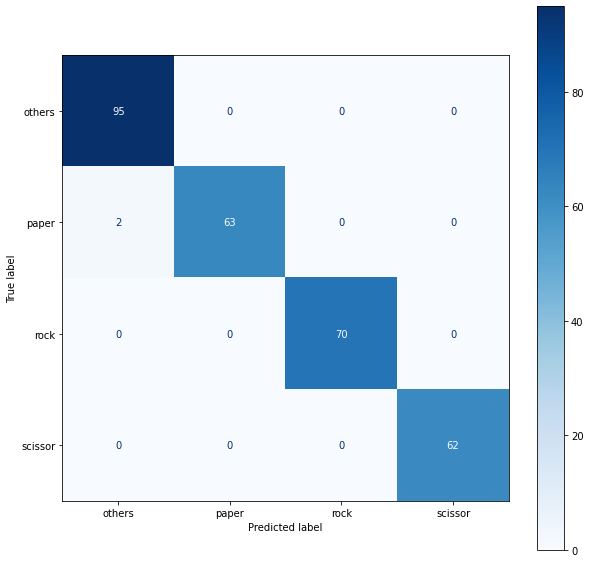

In [69]:
show_confusion_matrix(model=model_vgg16,
                      dataloader=test_loader_MyRPS,
                      class_names=class_names_MyRPS,
                      device=device)

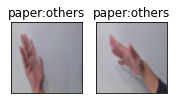

In [70]:
show_misrecognizd_images(model=model_vgg16,
                         dataloader=test_loader_MyRPS,
                         img_shape=(3, 56, 56),
                         class_names=class_names_MyRPS,
                         device=device)

## **Example 3.5.4** Realtime recognition using webcam

In [71]:
### reference: https://qiita.com/a2kiti/items/f32de4f51a31d609e5a5

import IPython
from google.colab import output
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def run(img_str):
    #decode to image
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))

    # decimg2 = np.array(decimg, dtype=np.uint8); 
    # decimg2 = cv2.cvtColor(decimg2, cv2.COLOR_BGR2RGB)
    # out_img = cv2.Canny(decimg2,100,200)
    

    #############your process###############
    img = transform_for_test(decimg)
    img = img.unsqueeze(0)
    img = img.to(device)
    outputs = model_vgg16(img)

    prediction = torch.max(outputs, 1)[1]
    pred_class = class_names_MyRPS[prediction[0]]
    
    decimg = np.array(decimg, dtype=np.uint8); 
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    out_img = decimg
    cv2.putText(out_img, pred_class, (10, 30), fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 1.0, color = (0,0,0))

    #############your process###############

    #encode to string
    _, encimg = cv2.imencode(".jpg", out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [57]:
from IPython.display import display, Javascript
from google.colab.output import eval_js

def use_cam(quality=0.8):
  js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 500 
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size * video.videoHeight / video.videoWidth;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);     
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);   
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
  display(js)
  data = eval_js('useCam({})'.format(quality))

In [76]:
use_cam()

<IPython.core.display.Javascript object>